# Read evaluation and generate tables and bar plots
Goal: reproduce result summaries from the platform to integrate them in the paper.

Note: some submissions did not provide predictions for both datasets, so we could either have 8 tables, or we could have 4 tables with a “left” part for Rumsey and a “right” part for IGN, (blank when an entry skipped one of the evaluations).
Which ranking to use is a bit ambiguous here.

Note: We do not change submission names, to ensure consistency with the online platform.
However, we shorten long submission names with ellipses, like for instance “MapText…Strong Pipeline”.
We apply the same function everywhere to make sure this is consistent across the various tasks.

In [1]:
from icdar_maptext_analysis.loaders import list_valid_submission_ids, VALID_TASKS, VALID_SUBSETS, load_valid_evaluations
from icdar_maptext_analysis.submissions_metadata import lookup_generate_title, shorten_title

In [2]:
import os
from IPython.display import display
import matplotlib.pyplot as plt

# original column names to report naming
columns_rename_map = {
    # "char_quality": "Char. Quality (%)",
    # "char_accuracy": "Char. Accuracy (%)",
    "char_quality": "Char. Quality",
    "char_accuracy": "Char. Acc.",
    # "quality": "Det. Quality (%)", 
    "quality": "Det. Quality", 
    # "tightness": "Det. Tightness (%)", 
    "tightness": "Tightness", 
    # "fscore": "Det. FScore (%)", 
    "fscore": "FScore", 
    # "precision": "Det. Precision (%)", 
    "precision": "Precision", 
    # "recall": "Det. Recall (%)",
    "recall": "Recall",
}

subset_rename_map = {
    "rumsey": "Rumsey",
    "ign": "French Land Register",
    "twh": "Chinese Historical Topographic Maps",
}

task_extra_description_for_table = {
    1: "isolated word detection",
    2: "grouped word detection",
    3: "word detection with perfect transcription",
    4: "joint grouped word detection and transcription",
}


def generate_all_tables_and_plot(output_dir: str):
    # get the list of valid submission ids
    valid_submission_ids = list_valid_submission_ids()
    # create output directory
    os.makedirs(output_dir, exist_ok=True)
    for task_id in VALID_TASKS:
        for subset in VALID_SUBSETS:
            # skip tasks 2 and 4 for subset twh
            if subset == "twh" and task_id in [2, 4]:
                continue
            subset_name = subset_rename_map[subset]
            print()
            print(f"Task {task_id}, \"{subset_name}\" subset")
            print("="*80)
            # read the results
            results_global, _results_per_image = load_valid_evaluations(task_id, subset)
            if len(results_global) == 0:
                print(f"No results for task {task_id} on {subset_name} subset")
                continue

            # add method names
            results_global["Method name"] = results_global.index.map(lambda idx: lookup_generate_title(int(idx[2])))
            # shorten the titles
            results_global["Method name"] = results_global["Method name"].map(shorten_title)

            # renames columns, sort them and scale their values
            # build the actual renaming map based on the columns present in the results
            columns_rename_map_actual = {k: v for k, v in columns_rename_map.items() if k in results_global.columns}
            results_global.rename(columns=columns_rename_map_actual, inplace=True)
            # get the list of actual columns
            actual_columns = list(columns_rename_map_actual.values())
            # report numbers as 0-100 (percentages) by multiplying by 100
            results_global[actual_columns] *= 100
            # display the results using html rendering
            all_columns = ["Method name"] + actual_columns

            # The sort key is the first columns which actually belongs to columns_rename_map (which is ordered by importance)
            sort_column = [col for col in columns_rename_map.values() if col in actual_columns][0]
            # Add a rank column
            results_global["Rank"] = results_global[sort_column].rank(ascending=False).astype(int)
            all_columns = ["Rank"] + all_columns

            # Display and save the results
            display(results_global[all_columns].sort_values(sort_column, ascending=False))
            # print the results as latex table, using 1 decimal place
            # latex_str = results_global[["Method name", "Quality (%)"]].sort_values(sort_column, ascending=False).to_latex(index=False, float_format="%.1f")
            latex_str = results_global[all_columns].sort_values(sort_column, ascending=False).to_latex(
                index=False,
                float_format="%.1f",
                column_format="cr" + "c" * (len(all_columns) - 2),
                caption=f"Results for task {task_id} ({task_extra_description_for_table[task_id]}) on {subset_name} subset. Values expressed in percentage. For all metrics, higher is better.",
                label=f"tab:task_{task_id}_subset_{subset}",
                position="!ht",
                escape=True,
                )
            # hugly hack to add a resizebox to the table
            latex_str = latex_str.replace(r"\begin{tabular}", r"\resizebox{\textwidth}{!}{\begin{tabular}").replace(r"\end{tabular}", r"\end{tabular}}")
            # print(latex_str)
            # export to file
            with open(os.path.join(output_dir, f"task_{task_id}_subset_{subset}.tex"), "w") as f:
                f.write(latex_str)

            # Increase text size
            plt.rcParams.update({'font.size': 14})
            # plot the results
            results_global[["Method name", sort_column]].sort_values(sort_column, ascending=False).plot.barh(
                x="Method name", y=sort_column, 
                # title=f"Score for task {task_id} on {subset_name} subset", 
                ylabel="", xlabel=sort_column, legend=False, 
                xlim=(0, 100))
            # flip y axis
            plt.gca().invert_yaxis()
            # Adjust layout to ensure labels are not cropped
            plt.tight_layout()
            # export to file
            plt.savefig(os.path.join(output_dir, f"task_{task_id}_subset_{subset}.pdf"), bbox_inches="tight")


Task 1, "Rumsey" subset


Rank                     Method name  \
task_id subset submission_id                                         
1       rumsey 124983            1         MapText Strong Pipeline   
               124940            2                  Self-Sequencer   
               125646            3        Baseline TESTR Finetuned   
               121832            4  [MapText'24 ...Strong Pipeline   
               125479            5                      PolyTextTR   
               124853            6                  MapTextSpotter   
               125456            7             CREPE + BezierCurve   
               125458            8            YOLOv8-ViTAE-Polygon   
               125481            9  Word-Level T...g and PaddleOCR   

                              Det. Quality  Tightness     FScore  Precision  \
task_id subset submission_id                                                  
1       rumsey 124983            78.573641  83.751618  93.817461  95.884297   
               124940            77.791857  86.137988  90.310743  91.518529   
               125646            77.298977  86.284971  89.585678  89.135593   
               121832            76.133776  82.747932  92.006863  94.190382   
               125479            73.420157  82.482398  89.013122  90.277101   
               124853            70.623066  81.448965  86.708364  92.609526   
               125456            63.913892  73.624769  86.810313  87.096716   
               125458            41.027235  74.371886  55.164978  54.095641   
               125481            35.362140  73.892059  47.856482  59.538449   

                                 Recall  
task_id subset submission_id             
1       rumsey 124983         91.837848  
               124940         89.134420  
               125646         90.040332  
               121832         89.922287  
               125479         87.784048  
               124853         81.514206  
               125456         86.525787  
               125458         56.277443  
               125481         40.006797


Task 1, "French Land Register" subset


Rank               Method name  Det. Quality  \
task_id subset submission_id                                                 
1       ign    125646            1  Baseline TESTR Finetuned     56.168753   
               125479            2                PolyTextTR     52.833954   
               125458            3      YOLOv8-ViTAE-Polygon     45.894543   

                              Tightness     FScore  Precision     Recall  
task_id subset submission_id                                              
1       ign    125646         69.809324  80.460245  80.738385  80.184015  
               125479         70.267735  75.189493  76.523285  73.901401  
               125458         68.466975  67.031650  63.452929  71.038176


Task 1, "Chinese Historical Topographic Maps" subset


Rank               Method name  Det. Quality  \
task_id subset submission_id                                                 
1       twh    124983            1   MapText Strong Pipeline     81.347481   
               125646            2  Baseline TESTR Finetuned     66.657551   
               125479            3                PolyTextTR     56.579585   
               125458            4      YOLOv8-ViTAE-Polygon     22.037242   

                              Tightness     FScore  Precision     Recall  
task_id subset submission_id                                              
1       twh    124983         87.456672  93.014608  96.527012  89.748847  
               125646         88.207058  75.569408  70.990991  80.779088  
               125479         82.356402  68.700895  65.467208  72.270630  
               125458         84.931865  25.946966  15.383334  82.816504


Task 2, "Rumsey" subset


Rank                     Method name  \
task_id subset submission_id                                         
2       rumsey 124938            1                  Self-Sequencer   
               125647            2  Baseline TES...+ Heuristic MST   
               125455            3             CREPE + BezierCurve   
               121864            4     [Baseline MapText'24] DS-LP   

                              Det. Quality  Tightness     FScore  Precision  \
task_id subset submission_id                                                  
2       rumsey 124938            77.791857  86.137988  90.310743  91.518529   
               125647            77.298977  86.284971  89.585678  89.135593   
               125455            63.913892  73.624769  86.810313  87.096716   
               121864            53.845988  71.629019  75.173427  71.756203   

                                 Recall  
task_id subset submission_id             
2       rumsey 124938         89.134420  
               125647         90.040332  
               125455         86.525787  
               121864         78.932401


Task 2, "French Land Register" subset


,,,Rank,Method name,Det. Quality,Tightness,FScore,Precision,Recall
task_id,subset,submission_id,,,,,,,
2,ign,125647,1,Baseline TES...+ Heuristic MST,56.168753,69.809324,80.460245,80.738385,80.184015



Task 3, "Rumsey" subset


Rank                     Method name  \
task_id subset submission_id                                         
3       rumsey 124985            1         MapText Strong Pipeline   
               124939            2                  Self-Sequencer   
               125648            3        Baseline TESTR Finetuned   
               121874            4  [Baseline Ma...Strong Pipeline   
               121875            5  [Baseline MapText '24] MapTest   
               121876            6  [Baseline Ma... MapTextSpotter   
               125454            7             CREPE + BezierCurve   
               121878            8  [Baseline Ma...ESTR Checkpoint   
               121877            9     [Baseline MapText'24] DS-LP   
               125480           10  Word-Level T...g and PaddleOCR   
               125463           11    YOLOv8_ViTAE_PolygonDetector   

                              Det. Quality  Tightness     FScore  Precision  \
task_id subset submission_id                                                  
3       rumsey 124985            78.571353  83.749179  93.817461  95.884297   
               124939            77.790679  86.136683  90.310743  91.518529   
               125648            77.297332  86.283135  89.585678  89.135593   
               121874            75.141418  83.265968  90.242652  96.162912   
               121875            73.092488  81.816676  89.336907  90.470689   
               121876            70.617272  81.442284  86.708364  92.609526   
               125454            63.913742  73.624596  86.810313  87.096716   
               121878            55.120872  79.549984  69.290865  71.854050   
               121877            53.843593  71.625832  75.173427  71.756203   
               125480            35.362140  73.892059  47.856482  59.538449   
               125463            12.673957  75.966185  16.683683  61.745005   

                                 Recall  
task_id subset submission_id             
3       rumsey 124985         91.837848  
               124939         89.134420  
               125648         90.040332  
               121874         85.009077  
               121875         88.231191  
               121876         81.514206  
               125454         86.525787  
               121878         66.904249  
               121877         78.932401  
               125480         40.006797  
               125463          9.644879


Task 3, "French Land Register" subset


Rank                   Method name  \
task_id subset submission_id                                       
3       ign    125648            1      Baseline TESTR Finetuned   
               125463            2  YOLOv8_ViTAE_PolygonDetector   

                              Det. Quality  Tightness     FScore  Precision  \
task_id subset submission_id                                                  
3       ign    125648            56.167849  69.808200  80.460245  80.738385   
               125463             8.187365  66.796917  12.257100  65.951743   

                                 Recall  
task_id subset submission_id             
3       ign    125648         80.184015  
               125463          6.756386


Task 3, "Chinese Historical Topographic Maps" subset


Rank                   Method name  \
task_id subset submission_id                                       
3       twh    124985            1       MapText Strong Pipeline   
               125648            2      Baseline TESTR Finetuned   
               125463            3  YOLOv8_ViTAE_PolygonDetector   

                              Det. Quality  Tightness     FScore  Precision  \
task_id subset submission_id                                                  
3       twh    124985            81.341653  87.450407  93.014608  96.527012   
               125648            66.650745  88.198051  75.569408  70.990991   
               125463            36.690909  85.274823  43.026661  35.908428   

                                 Recall  
task_id subset submission_id             
3       twh    124985         89.748847  
               125648         80.779088  
               125463         53.664787


Task 4, "Rumsey" subset


Rank                     Method name  \
task_id subset submission_id                                         
4       rumsey 124937            1                  Self-Sequencer   
               125651            2  Baseline TES...+ Heuristic MST   
               125336            3             CREPE + BezierCurve   
               121883            4     [Baseline MapText'24] DS-LP   

                              Char. Quality  Char. Acc.  Det. Quality  \
task_id subset submission_id                                            
4       rumsey 124937             73.793830   94.862047     77.790679   
               125651             71.821156   92.915440     77.297332   
               125336             61.020855   95.473764     63.913742   
               121883             48.904712   90.827356     53.843593   

                              Tightness     FScore  Precision     Recall  
task_id subset submission_id                                              
4       rumsey 124937         86.136683  90.310743  91.518529  89.134420  
               125651         86.283135  89.585678  89.135593  90.040332  
               125336         73.624596  86.810313  87.096716  86.525787  
               121883         71.625832  75.173427  71.756203  78.932401


Task 4, "French Land Register" subset


,,,Rank,Method name,Char. Quality,Char. Acc.,Det. Quality,Tightness,FScore,Precision,Recall
task_id,subset,submission_id,,,,,,,,,
4,ign,125651,1,Baseline TES...+ Heuristic MST,49.946164,88.92305,56.167849,69.8082,80.460245,80.738385,80.184015


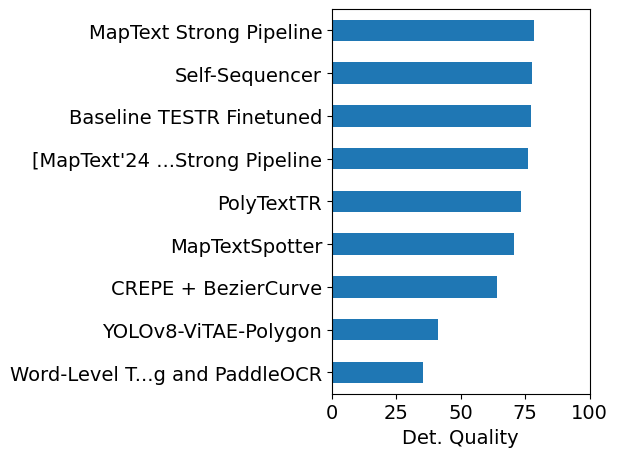

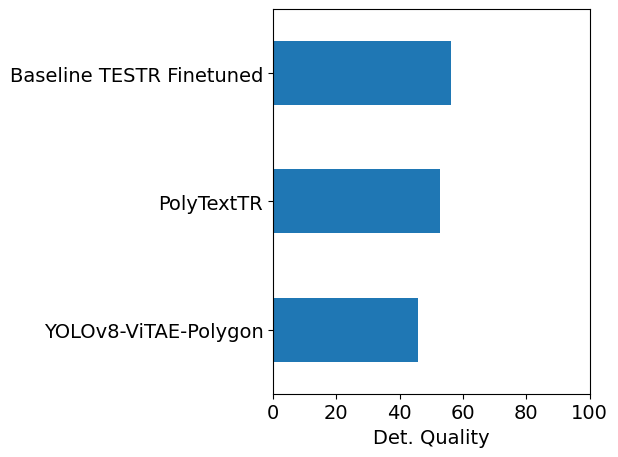

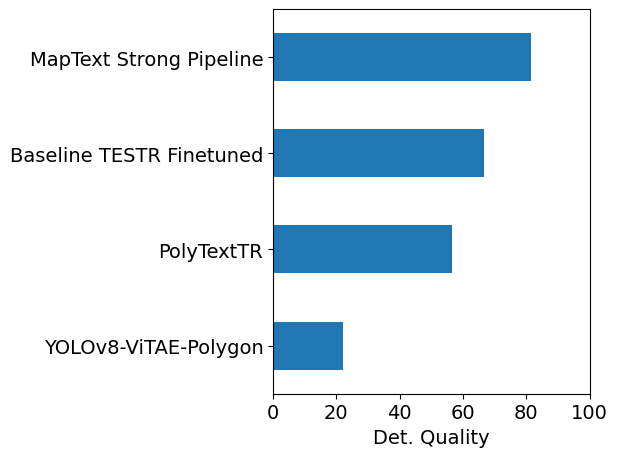

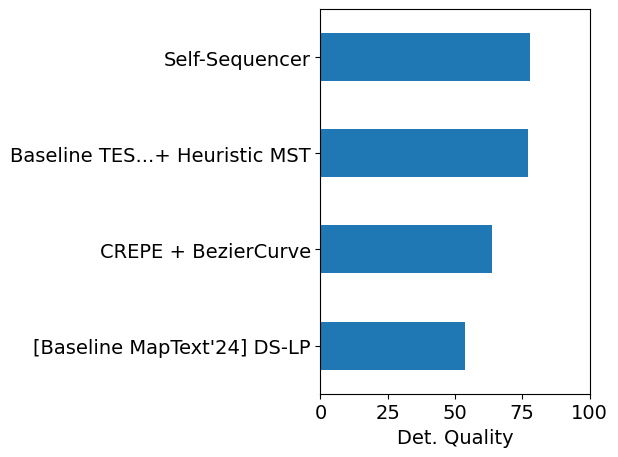

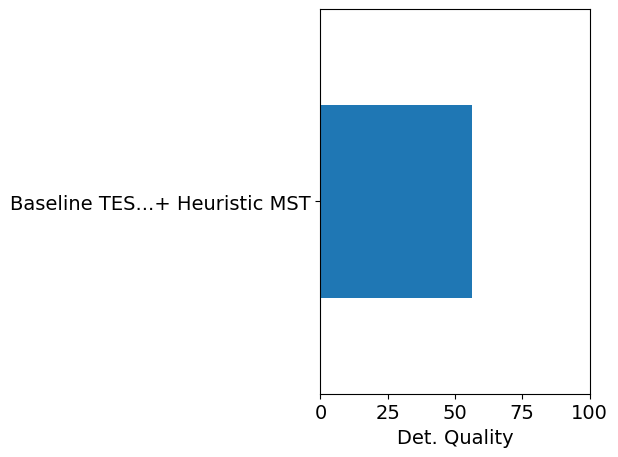

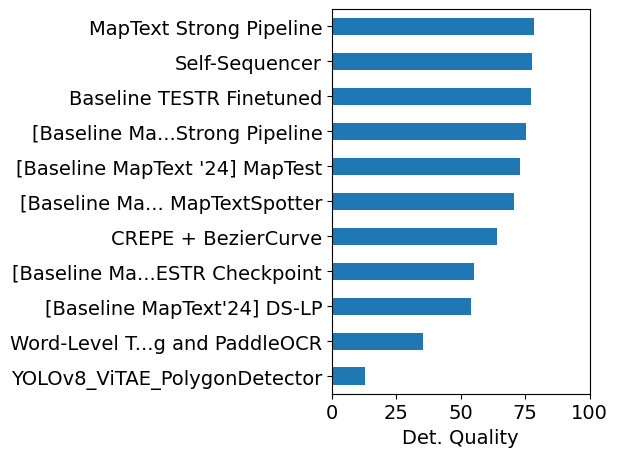

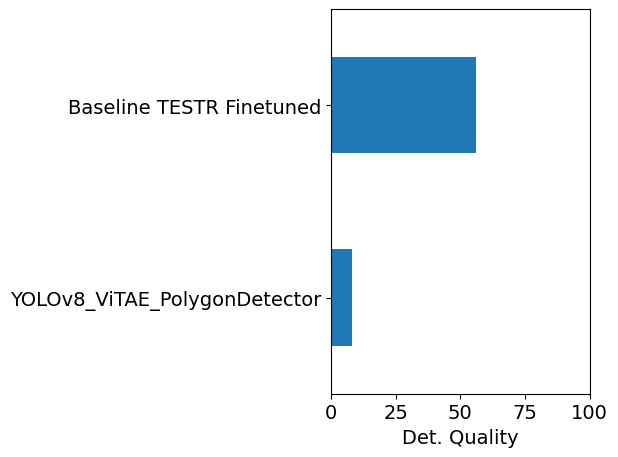

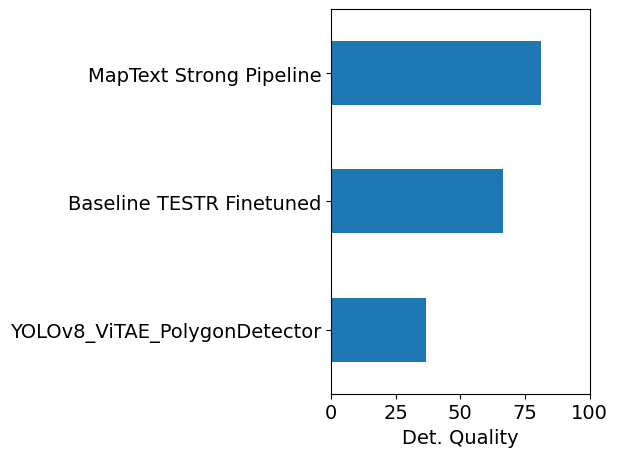

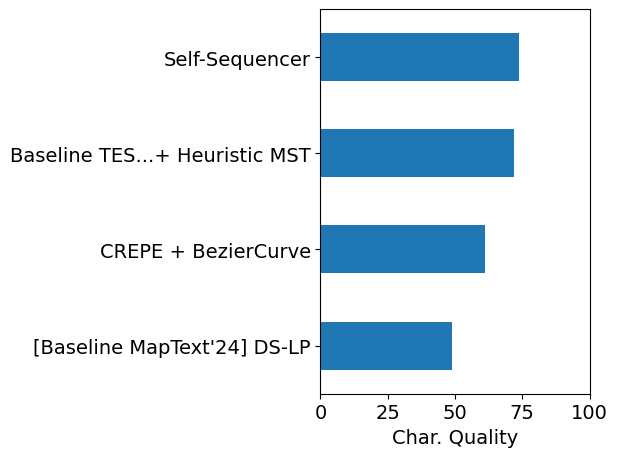

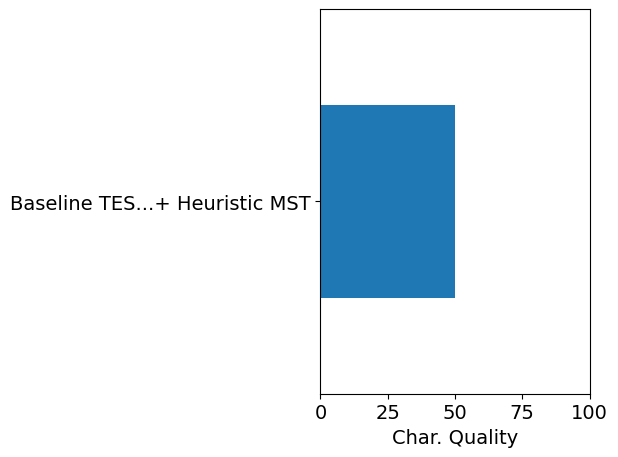

In [3]:
generate_all_tables_and_plot("data/10-tables-and-plots/")